# 2025.1105

process LOD data

> The Length of Day (LOD) is a measure of the difference between the observed and nominal (86,400 s) duration of a day (Gross, 2015). LOD is variable over time, with variations ranging from subdaily to geological time scales. It has been shown that the secular trend on geological time scale is caused almost entirely by the opposing actions of lunar tidal friction and Glacial Isostatic Adjustment (GIA, Kiani Shahvandi, Adhikari, Dumberry, Mishra, & Soja, 2024). Atmosphere and, to a lesser degree oceans, are the main drivers of LOD variations up to interannual time scales (see Gross, 2015 and references therein for a review).  
> (Shahvandi+ 2024)

> LOD data were obtained from the Earth orientation center at <https://hpiers.obspm.fr/eop-pc/index.php>  
> (Rosat & Gillet, 2023).

Daily data is obtained from IERS C04 solution <https://hpiers.obspm.fr/eop-pc/index.php?index=C04>

In [1]:
import platform
import sys # python 3.9.16
import os

import numpy             as np # numpy 1.23.2
np.set_printoptions(precision=5, floatmode='fixed', suppress=True)

import pandas            as pd # pandas 2.0.3
from datetime import datetime, timedelta

import matplotlib        as mpl # matplotlib 3.7.1
import matplotlib.pyplot as plt

print(f"Python Platform: {platform.platform()}")
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f" Numpy {np.__version__}")
print(f"Matplotlib {mpl.__version__}")

Python Platform: macOS-15.5-arm64-arm-64bit
Python 3.9.22 | packaged by conda-forge | (main, Apr 14 2025, 23:36:04) 
[Clang 18.1.8 ]
Pandas 2.1.4
 Numpy 1.23.2
Matplotlib 3.7.1


## READ DATA

In [2]:
# 小数年（Fractional Year）を計算する関数を定義
def get_fractional_year(date):
    """
    datetimeオブジェクトから小数年を計算する。
    その日の正午を想定し、Year + (DayOfYear - 0.5) / DaysInYear を採用。
    """
    year = date.year
    day_of_year = date.timetuple().tm_yday
    
    # その年の総日数を計算 (うるう年を考慮)
    if (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0):
        days_in_year = 366
    else:
        days_in_year = 365
    
    # 日付をその日の真ん中 (正午) に対応させる: (通算日 - 0.5)
    fractional_year = year + (day_of_year - 0.5) / days_in_year
    return fractional_year

In [3]:
def read_iers_data(file_path):
    # データの読み込み
    # ヘッダー行をスキップし、スペース区切りで読み込みます。
    df = pd.read_csv(
        file_path,
        sep='\s+',
        skiprows=2,
        header=None,
        names=['Year', 'Month', 'Day', 'lod', 'sigma'],
        engine='python' # '\s+'を使うため
    )

    # 日付オブジェクト (datetime) の作成
    df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
    # 小数年の計算を適用
    df['Fractional_Year'] = df['Date'].apply(get_fractional_year)
    
    return df

In [4]:
def read_nasa_data(file_path):
    """
    JPLのExcess LODデータファイルを読み込み、MJDを小数年（Fractional_Year）に変換した
    DataFrameを返す関数。
    
    Args:
        file_path (str): データファイル (.dat) へのパス。
        
    Returns:
        pd.DataFrame: 小数年、LODS (ms)、LODSIG (ms) を含むDataFrame。
    """
    
    # MJDの基準日 (0.0) は 1858年11月17日 00:00:00 UTC
    MJD_REF_DATE = datetime(1858, 11, 17)
    
    # データの構造に基づき、コメントとヘッダーをスキップして読み込む。
    # 最初のデータ行 (37684.500...) の直前までをスキップ
    # (ファイルの内容から、約32行をスキップするとデータ部分に到達すると仮定します)
    try:
        df = pd.read_csv(
            file_path, 
            sep=r'\s+',              # 複数のスペースを区切り文字として使用
            skiprows=34,             # 適切なスキップ行数を指定
            engine='python',         # 正規表現区切り文字を使用するため'python'エンジンを指定
            names=['MJD', 'LODS (ms)', 'LODSIG (ms)'] # 列名を指定
        )
    except FileNotFoundError:
        print(f"エラー: ファイル '{file_path}' が見つかりません。")
        return pd.DataFrame()
    except Exception as e:
        print(f"データの読み込み中にエラーが発生しました: {e}")
        return pd.DataFrame()

    print(f"データの読み込みに成功しました。行数: {len(df)}")
    
    # 1. MJDからDatetimeオブジェクトへの変換
    # MJDは半日単位 (0.5) で記録されているため、1日あたりの秒数で換算し、
    # timedeltaとして基準日に加算します。
    # ここでのMJDの値 (例: 37684.500) は日数を表します。
    # 文字列として読み込まれたMJD列を浮動小数点数に変換
    df['MJD'] = df['MJD'].astype(float)
    df['Datetime'] = df['MJD'].apply(lambda mjd: MJD_REF_DATE + timedelta(days=mjd))
    
    # 2. Datetimeから小数年 (Fractional Year) への変換
    df['Fractional_Year'] = df['Datetime'].apply(get_fractional_year)
    
    # 3. 最終的なDataFrameの整形
    # MJDと一時的なDatetime列を削除し、列の順番を整えます。
    df = df[['Fractional_Year', 'LODS (ms)', 'LODSIG (ms)']]
    
    print("MJDからFractional_Yearへの変換が完了しました。")
    return df

In [5]:
read_src = "../MCM2024/raw/iers_C04_daily_raw_2000-2025.lod"
lod_raw_df = read_iers_data(read_src)
lod_raw_df.head()

,Year,Month,Day,lod,sigma,Date,Fractional_Year
0,2000,1,1,0.9394,0.0274,2000-01-01,2000.001366
1,2000,1,2,0.8034,0.0289,2000-01-02,2000.004098
2,2000,1,3,0.6680,0.0282,2000-01-03,2000.006831
3,2000,1,4,0.5441,0.0258,2000-01-04,2000.009563
4,2000,1,5,0.4369,0.0243,2000-01-05,2000.012295


In [6]:
read_src = "../MCM2024/raw/iers_C04_daily_rmTidal_2000-2025.lod"
lod_rmT_df = read_iers_data(read_src)
lod_rmT_df.head()

,Year,Month,Day,lod,sigma,Date,Fractional_Year
0,2000,1,1,0.9718,0.0274,2000-01-01,2000.001366
1,2000,1,2,0.9506,0.0289,2000-01-02,2000.004098
2,2000,1,3,0.9314,0.0282,2000-01-03,2000.006831
3,2000,1,4,0.9115,0.0258,2000-01-04,2000.009563
4,2000,1,5,0.8827,0.0243,2000-01-05,2000.012295


In [7]:
read_src = "../MCM2024/raw/nasa_comb2023_noon.lod"
lod_jpl_df = read_nasa_data(read_src)
lod_jpl_df.head()

データの読み込みに成功しました。行数: 22807
MJDからFractional_Yearへの変換が完了しました。


,Fractional_Year,LODS (ms),LODSIG (ms)
0,1962.053425,1.0514,0.1153
1,1962.056164,1.0424,0.1137
2,1962.058904,1.0357,0.1125
3,1962.061644,1.0312,0.1115
4,1962.064384,1.0290,0.1107


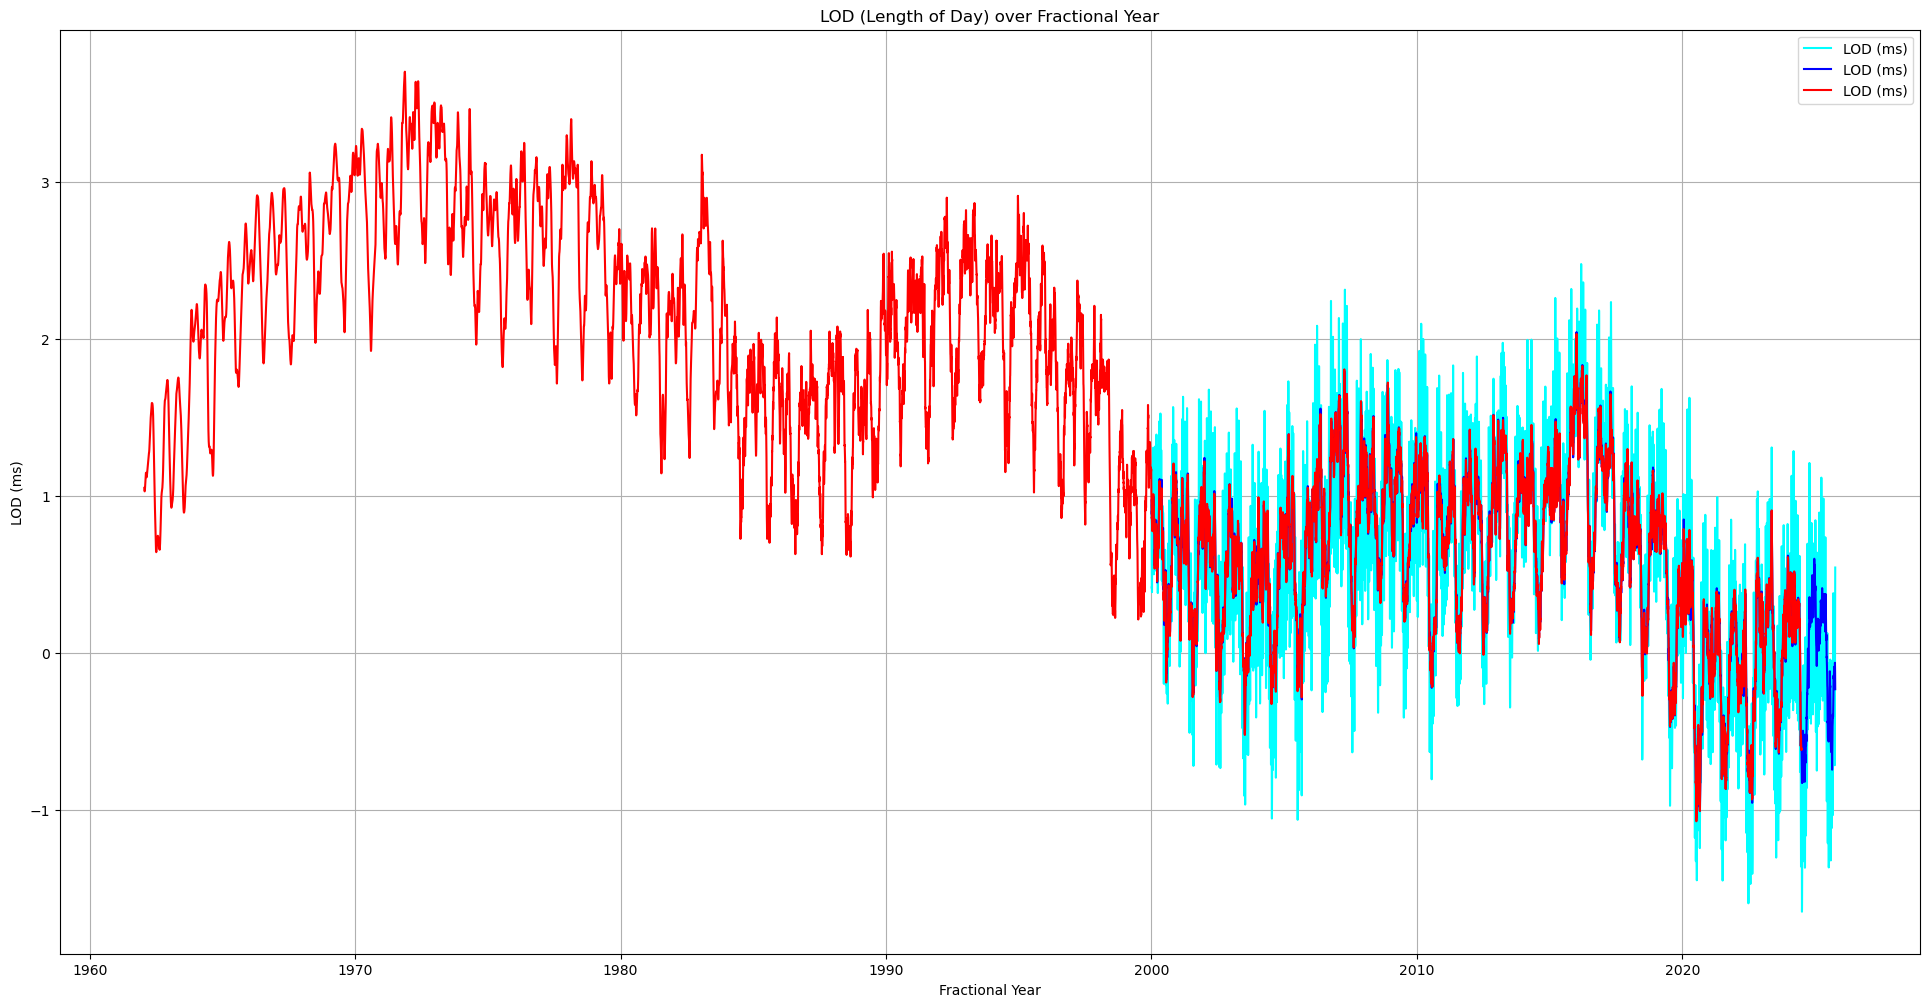

In [8]:
# プロット
plt.figure(figsize=(24, 12))
plt.plot(lod_raw_df['Fractional_Year'], lod_raw_df['lod'], label='LOD (ms)', color='cyan')
plt.plot(lod_rmT_df['Fractional_Year'], lod_rmT_df['lod'], label='LOD (ms)', color='blue')
plt.plot(lod_jpl_df['Fractional_Year'], lod_jpl_df['LODS (ms)'], label='LOD (ms)', color='red')
plt.title('LOD (Length of Day) over Fractional Year')
plt.xlabel('Fractional Year')
plt.ylabel('LOD (ms)')
plt.grid(True)
plt.legend()
plt.show()

## process LOD data to 0.25 yr interval

1 yr MOVING-AVERAGE filtering to remove seasonal variation (AAM, OAM effects)

In [9]:
def interpolate_to_quarterly(df_daily, target_times, value_col='lod', time_col='Fractional_Year'):
    """
    日次データ (Fractional Year) を特定の四半期時系列に平均化する。
    
    ターゲットとなる時間点 t を中心とする [t - 0.125, t + 0.125) の期間の
    元のデータの平均値と標準偏差を計算する。

    Args:
        df_daily (pd.DataFrame): 日次データフレーム。
        target_times (np.array): 平均化したい小数年時系列。
        value_col (str): 平均化する値の列名 ('lod'など)。
        time_col (str): 小数年が入っている列名 ('Fractional_Year')。

    Returns:
        pd.DataFrame: 四半期平均値と四半期時間のデータフレーム。
    """
    results = []
    
    # ターゲット時間点 t を中心とする平均化の半期間 (0.25年/2)
    #half_period = (1999.1251 - 1999.3753) / -2  # 約0.125年
    half_period = 0.5  # 1年周期をフィルタリング
    
    for t in target_times:
        # ターゲット時間点 t を中心とする 0.25 年の窓内のデータを選択
        window_start = t - half_period
        window_end = t + half_period
        
        # DataFrameのフィルタリング
        window_data = df_daily[
            (df_daily[time_col] >= window_start) & 
            (df_daily[time_col] < window_end)
        ]
        
        avg_lod = np.nan
        std_lod = np.nan
        
        if not window_data.empty:
            # 窓内にデータがある場合のみ平均値と標準偏差を計算
            avg_lod = window_data[value_col].mean()
            std_lod = window_data[value_col].std()
        
        results.append({
            'YEAR': t,
            f'avg_{value_col}': avg_lod,
            f'std_{value_col}': std_lod
        })
    
    df_quarterly = pd.DataFrame(results)
    df_quarterly.set_index('YEAR', inplace=True)
    return df_quarterly

In [10]:
# --- データの前処理 (前回の結果を使用) ---
# df_daily (日次データフレーム) が前回の実行により準備されていると仮定

# ターゲット時間点
target_times = [1999.1251, 1999.3753, 1999.6254, 1999.8756, 
                2000.1254, 2000.3749, 2000.6244, 2000.8739, 
                2001.1237, 2001.3739, 2001.6241, 2001.8742, 
                2002.1244, 2002.3746, 2002.6247, 2002.8749, 
                2003.1251, 2003.3753, 2003.6254, 2003.8756, 
                2004.1254, 2004.3749, 2004.6244, 2004.8739, 
                2005.1237, 2005.3739, 2005.6241, 2005.8742, 
                2006.1244, 2006.3746, 2006.6247, 2006.8749, 
                2007.1251, 2007.3753, 2007.6254, 2007.8756, 
                2008.1254, 2008.3749, 2008.6244, 2008.8739, 
                2009.1237, 2009.3739, 2009.6241, 2009.8742, 
                2010.1244, 2010.3746, 2010.6247, 2010.8749, 
                2011.1251, 2011.3753, 2011.6254, 2011.8756, 
                2012.1254, 2012.3749, 2012.6244, 2012.8739, 
                2013.1237, 2013.3739, 2013.6241, 2013.8742, 
                2014.1244, 2014.3746, 2014.6247, 2014.8749, 
                2015.1251, 2015.3753, 2015.6254, 2015.8756, 
                2016.1254, 2016.3749, 2016.6244, 2016.8739, 
                2017.1237, 2017.3739, 2017.6241, 2017.8742, 
                2018.1244, 2018.3746, 2018.6247, 2018.8749, 
                2019.1251, 2019.3753, 2019.6254, 2019.8756, 
                2020.1254, 2020.3749, 2020.6244, 2020.8739, 
                2021.1237, 2021.3739, 2021.6241, 2021.8742, 
                2022.1244, 2022.3746, 2022.6247, 2022.8749, 
                2023.1251, 2023.3753, 2023.6254, 2023.8756, 
                2024.1254, 2024.3749, 2024.6244, 2024.8739, 
                2025.1237, 2025.3739, 2025.6241, 2025.8742, 
                2026.1244, 2026.3746, 2026.6247, 2026.8749, 
                2027.1251, 2027.3753, 2027.6254, 2027.8756, 
                2028.1254, 2028.3749, 2028.6244, 2028.8739, 
                2029.1237, 2029.3739, 2029.6241, 2029.8742, 
                2030.1244, 2030.3746, 2030.6247, 2030.8749]
target_times = np.array(target_times)

# 関数を実行
lod_raw_qave = interpolate_to_quarterly(lod_raw_df, target_times, value_col='lod')
lod_rmT_qave = interpolate_to_quarterly(lod_rmT_df, target_times, value_col='lod')

display(lod_raw_qave.head())
display(lod_rmT_qave.head())

,avg_lod,std_lod
YEAR,,
1999.1251,NaN,NaN
1999.3753,NaN,NaN
1999.6254,0.861550,0.272399
1999.8756,0.945570,0.286076
2000.1254,0.681828,0.453730


,avg_lod,std_lod
YEAR,,
1999.1251,NaN,NaN
1999.3753,NaN,NaN
1999.6254,0.845520,0.110540
1999.8756,0.814677,0.155751
2000.1254,0.638294,0.324333


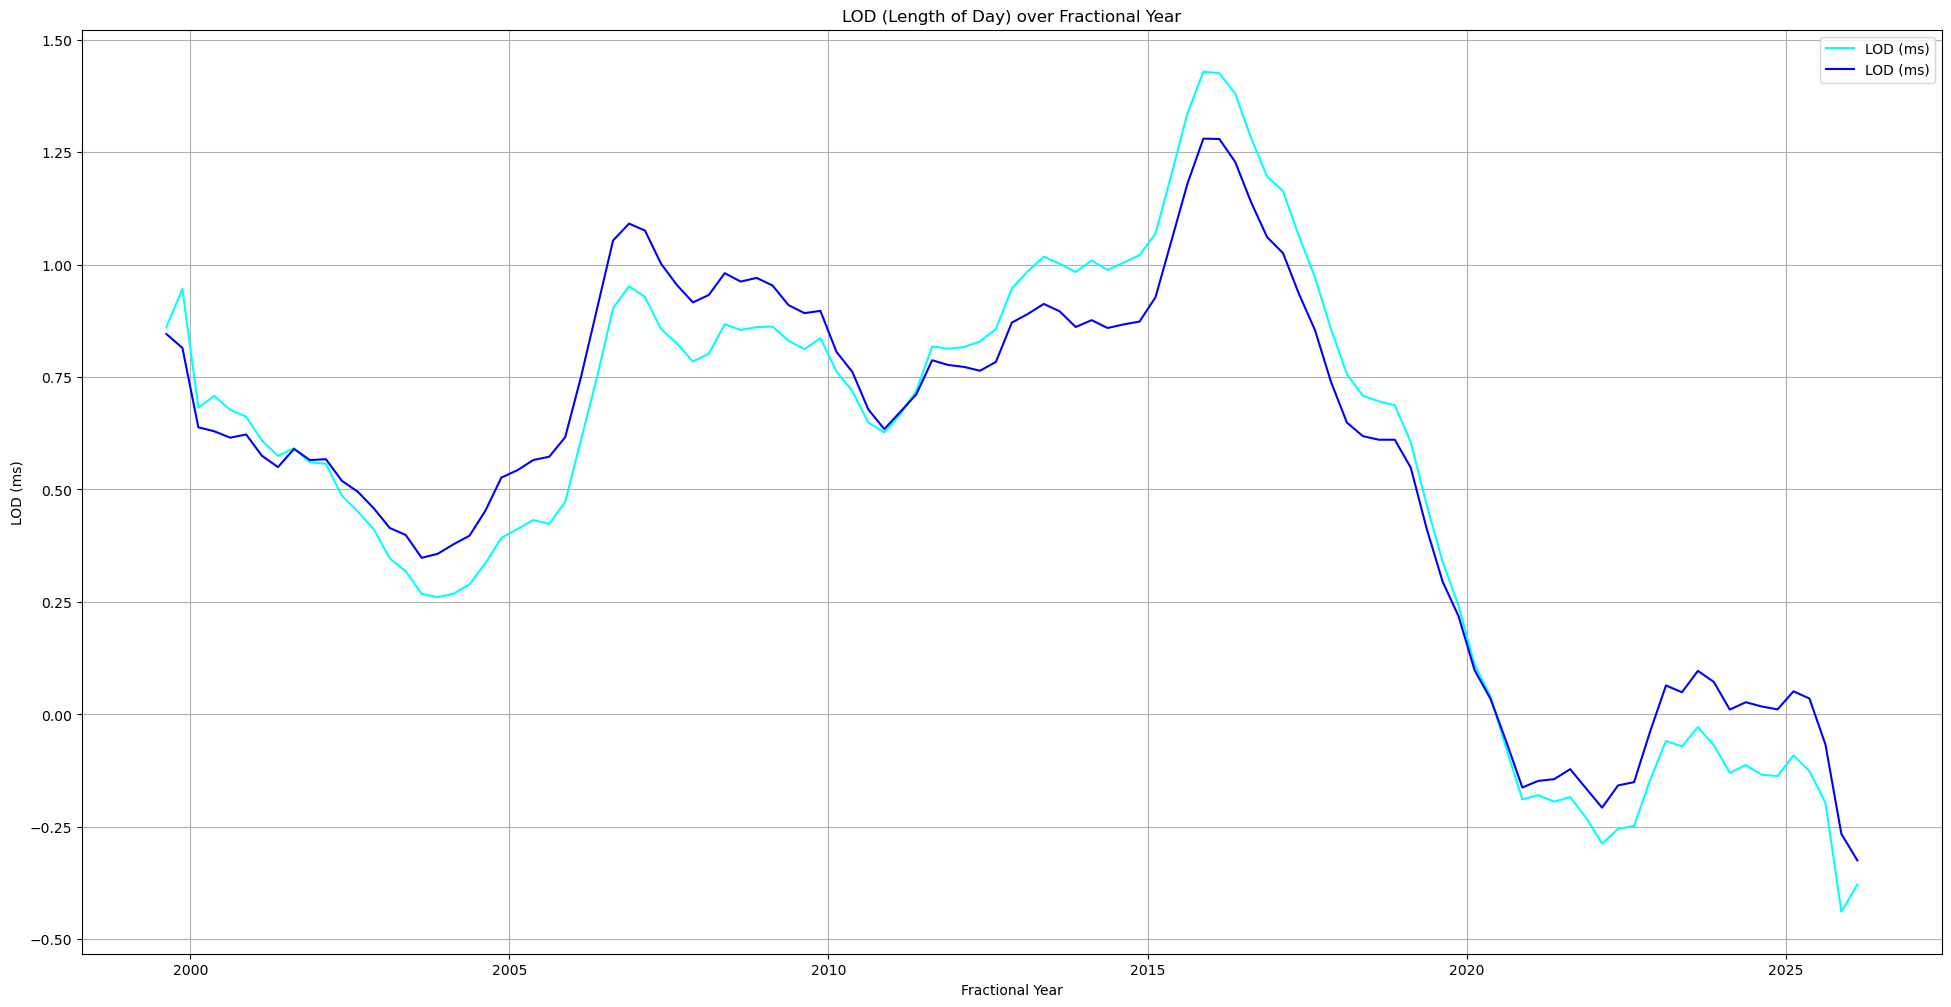

In [11]:
# プロット
plt.figure(figsize=(24, 12))
lod_raw_qave['avg_lod'].plot(label='LOD (ms)', color='cyan')
lod_rmT_qave['avg_lod'].plot(label='LOD (ms)', color='blue')
plt.title('LOD (Length of Day) over Fractional Year')
plt.xlabel('Fractional Year')
plt.ylabel('LOD (ms)')
plt.grid(True)
plt.legend()
plt.show()

In [12]:
#save
save_df = lod_rmT_qave.iloc[23:]
display(save_df.head())

save_dir = "../MCM2024/processed"
save_df.to_csv(f"{save_dir}/lod.csv")



,avg_lod,std_lod
YEAR,,
2004.8739,0.526483,0.418648
2005.1237,0.542717,0.391440
2005.3739,0.565489,0.384749
2005.6241,0.572782,0.394213
2005.8742,0.616196,0.433872


# Visualizations

In [13]:
%matplotlib inline
# print(plt.rcParams.keys())
plt.rcParams.update({
    'font.size'     : 16,
    'axes.grid'     : True,
    'grid.linestyle': '--',
    'lines.linewidth': 2,
})

# font size
f_large  = 24
f_medium = 18
f_small  = 16
f_tiny   = 12

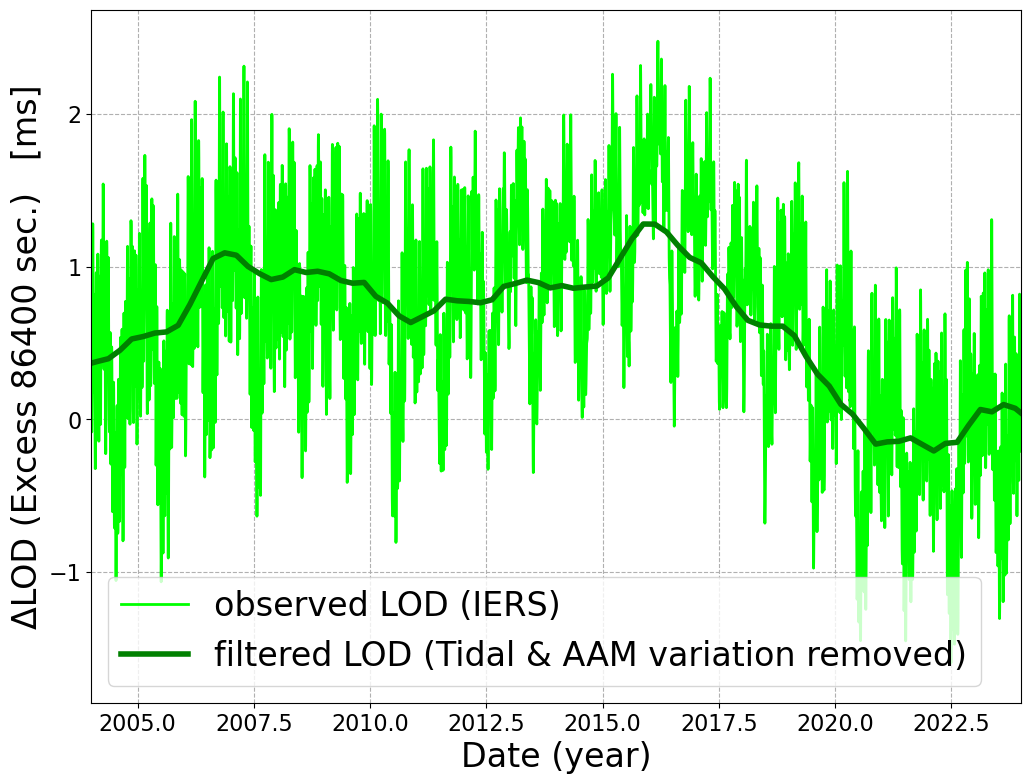

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

ax.plot(lod_raw_df['Fractional_Year'], lod_raw_df['lod'], 
        color='lime', linewidth=2.0, 
        label='observed LOD (IERS)')
ax.plot(lod_rmT_qave.index.values, lod_rmT_qave['avg_lod'], 
        color='green', linewidth=4.0, 
        label='filtered LOD (Tidal & AAM variation removed)')

ax.set_xlim(2004, 2024)
ax.set_xlabel('Date (year)', fontsize=f_large)
ax.set_ylabel("ΔLOD (Excess 86400 sec.)   [ms]", fontsize=f_large)

ax.legend(loc='lower left', fontsize=f_large)
plt.show()

0.002737688371775942 9411
0.002737688371775942 9411


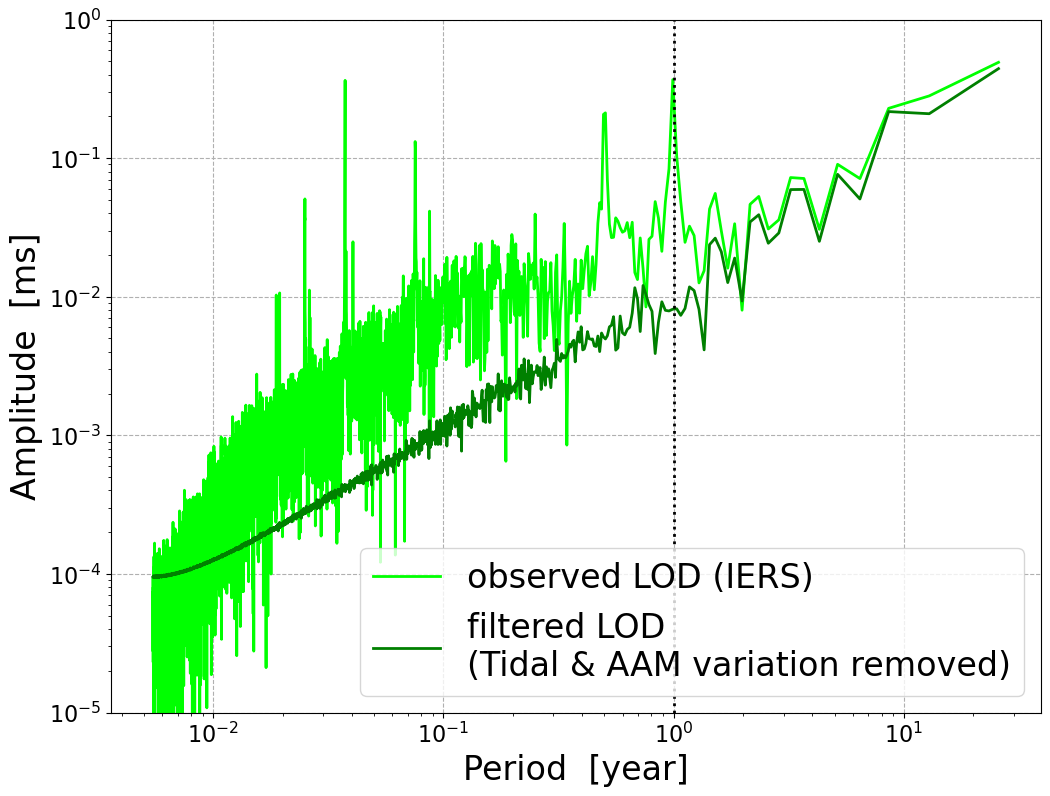

In [44]:
## FFT

daily = lod_raw_df['Fractional_Year'].diff().mean() # 1 day in year
N_raw = lod_raw_df['lod'].count()
print(daily, N_raw)
raw_fft = np.fft.fft(lod_raw_df['lod'])
raw_frq = np.fft.fftfreq(N_raw, d=daily)
raw_Amp = abs(raw_fft/(N_raw/2))

rmT_fft = np.fft.fft(lod_rmT_df['lod'])
rmT_frq = np.fft.fftfreq(N_raw, d=daily)
rmT_Amp = abs(rmT_fft/(N_raw/2))


# qyrly = 0.2502 # 0.25 yr
# N_flt = lod_rmT_qave['avg_lod'].count()
# print(qyrly, N_flt)
# flt_fft = np.fft.fft(lod_rmT_qave['avg_lod'])
# flt_frq = np.fft.fftfreq(N_flt, d=qyrly)
# flt_Amp = abs(flt_fft/(N_flt/2))
# failed: samplping rate was not enough for FFT

lod_flt_df = interpolate_to_quarterly(lod_rmT_df, lod_rmT_df['Fractional_Year'], value_col='lod')
N_flt = lod_flt_df['avg_lod'].count()
print(daily, N_flt)
flt_fft = np.fft.fft(lod_flt_df['avg_lod'])
flt_frq = np.fft.fftfreq(N_flt, d=daily)
flt_Amp = abs(flt_fft/(N_flt/2))

fig, ax = plt.subplots(1, 1, figsize=(12, 9))



ax.plot(1/raw_frq[1:int(N_raw/2)], raw_Amp[1:int(N_raw/2)], 
        color='lime', linewidth=2.0, 
        label="observed LOD (IERS)") #A-f グラフのプロット

# ax.plot(1/rmT_frq[1:int(N_raw/2)], rmT_Amp[1:int(N_raw/2)], 
#         color='cyan', linewidth=2.0, 
#         label="Tidal-removed LOD (IERS)") #A-f グラフのプロット

ax.plot(1/flt_frq[1:int(N_flt/2)], flt_Amp[1:int(N_flt/2)], 
        color='green', linewidth=2.0, 
        label='filtered LOD \n(Tidal & AAM variation removed)') #A-f グラフのプロット

ymin, ymax = 0.00001, 1
ax.set_ylim(ymin, ymax)
ax.plot((1, 1), (ymin, ymax), color="black", linestyle="dotted")

ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_ylim(0.001, 1)

ax.set_xlabel("Period  [year]" , fontsize=f_large)
ax.set_ylabel("Amplitude  [ms]", fontsize=f_large)
ax.legend(loc='lower right', fontsize=f_large)
plt.show()